# Исследование поведения пользователей в мобильном приложении по продаже продуктов питания

# Описание данных файла

Каждая запись в логе — это действие пользователя, или событие. 

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Задачи

- Разобраться, как ведут себя пользователи вашего мобильного приложения. 
- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. 

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go
import plotly.io as pio

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


# 1.Подготовка данных

Поменяю назания столбцов на удобные для моего использования с учетом змеиного регистра:
- EventName ("Название события") на **event_name**
- DeviceIDHash ("Уникальный идентификатор пользователя") на **user_id**
- EventTimestamp ("Время события") на **date_time**
- ExpId ("Номер эксперимента") на **group**

In [3]:
df = df.rename(columns={'EventName':'event_name',
                        'DeviceIDHash':'user_id',
                        'EventTimestamp':'date_time',
                        'ExpId':'group'
                       }
              )
df.columns

Index(['event_name', 'user_id', 'date_time', 'group'], dtype='object')

In [4]:
# Зафиксирую размер исходного датафрейма
print('Количество строк в датафрейме до обработки данных:', len(df))

Количество строк в датафрейме до обработки данных: 244126


In [5]:
# Посмотрю общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   date_time   244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- Пропусков нет.
- Столбец date_time представлен в формате unix time. Переведу его в формат datetime.

In [6]:
df['date_time'] = pd.to_datetime(df['date_time'], unit='s')
print(df['date_time'].dtype)

datetime64[ns]


In [7]:
# Из столбца date_time выделю дату и сохраню ее в отдельный столбец event_date
df['event_date'] = pd.to_datetime(df['date_time'].dt.date)

In [8]:
df.head()

,event_name,user_id,date_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Проверю таблицу на явные дубликаты. Выведу долю дубликатов в исходном датафрейме.

In [9]:
print('Процент дубликатов:', "{0:.2%}".format(df.duplicated().mean()))

Процент дубликатов: 0.17%


Дубликаты составляют всего 0,17%. Их удаление не сильно повлияет на дальнейшее исследование. Удаляю их.

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

In [11]:
# Проверю значения столбца event_name на предмет неявных дубликатов
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего 5 значений и все они уникальны. Для себя добавлю перевод значений:
- `MainScreenAppear` - "Главная страница"
- `PaymentScreenSuccessful` - "Страница успешной оплаты"
- `CartScreenAppear` - "Страница корзины"
- `OffersScreenAppear` - "Страница предложений"
- `Tutorial` - "Руководство"

Проверю уникальные значения столбца group. Должно быть только 3 значения: 246, 247, 248

In [12]:
df['group'].sort_values().unique()

array([246, 247, 248])

Для удобства работы заменю номера групп на названия:
- 246 - А1
- 247 - А2
- 248 - В

In [13]:
df['group'] = df['group'].replace(246, 'A1')
df['group'] = df['group'].replace(247, 'A2')
df['group'] = df['group'].replace(248, 'B')

In [14]:
# Проверю, что значения в столбце изменились
df.head()

,event_name,user_id,date_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [15]:
# Создам переменную id пользователей в группе А1
user_a1 = df[df['group'] == 'A1']['user_id']
# Создам переменную id пользователей в группе А2
user_a2 = df[df['group'] == 'A2']['user_id']
# Создам переменную id пользователей в группе B
user_b = df[df['group'] == 'B']['user_id']

# Сделаю срез таблицы df , в котором id пользователей одновременно есть и в группе А1 и в группе A2. 
#Вынесу его в отдельную переменную
id_a1a2 = df.query('user_id in @user_a1 and user_id in @user_a2')

# Сделаю срез таблицы df , в котором id пользователей одновременно есть и в группах А1 и B или А2 и В. 
#Вынесу его в отдельную переменную
id_a1a2b = df.query('(user_id in @user_a1 or user_id in @user_a2) and user_id in @user_b')


print('Количество пользователей одновременно в группах A1 и A2:', id_a1a2['user_id'].nunique())
print('Количество пользователей одновременно в группах A1 и B или A2 и B:', id_a1a2b['user_id'].nunique())


Количество пользователей одновременно в группах A1 и A2: 0
Количество пользователей одновременно в группах A1 и B или A2 и B: 0


Ни один пользователь не попал одновременно в несколько групп. Отлично!

In [16]:
# Выведу количество сктрок, которое осталось в датафрейме после предобработки данных
print('Количество строк в датафрейме после обработки данных:', len(df))

Количество строк в датафрейме после обработки данных: 243713


**Вывод**

Во время подготовки данных сделала следующее:
- Изменила названия столбцов на удоьные для понимания и для работы
- Изменила тип данных столбца date_time, чтобы с ним было удобно работать
- Создала отдельный столбец с датой
- Нашла явные дубликаты. Т.к. их процент был небольшой, избавилась от них
- Проверила на неявные дубликаты и убедилась, что их нет
- Проверила какие группы входят в датафрейм, изменила их названия на удобные для работы
- Проверила пользователей на попадание сразу в несколько групп и убедилась, что таких пользователей нет

# 2 Изучение и проверка данных.

In [17]:
print('Всего событий в логе:', len(df))
print('-'*50)
print('Всего пользователей в логе:', df['user_id'].nunique())
print('-'*50)
print('Среднее количество событий на одного пользователя:', df.groupby('user_id').agg({'event_name':'count'}).median()[0])
print('-'*50)
print(f"Располагаем данными с {df['event_date'].min()} по {df['event_date'].max()}, что составляет {df['event_date'].max() - df['event_date'].min()} дней ")

Всего событий в логе: 243713
--------------------------------------------------
Всего пользователей в логе: 7551
--------------------------------------------------
Среднее количество событий на одного пользователя: 20.0
--------------------------------------------------
Располагаем данными с 2019-07-25 00:00:00 по 2019-08-07 00:00:00, что составляет 13 days 00:00:00 дней 


Посмотрю на распределение количества событий по датам, чтобы убедиться, что данные полные за вест период.

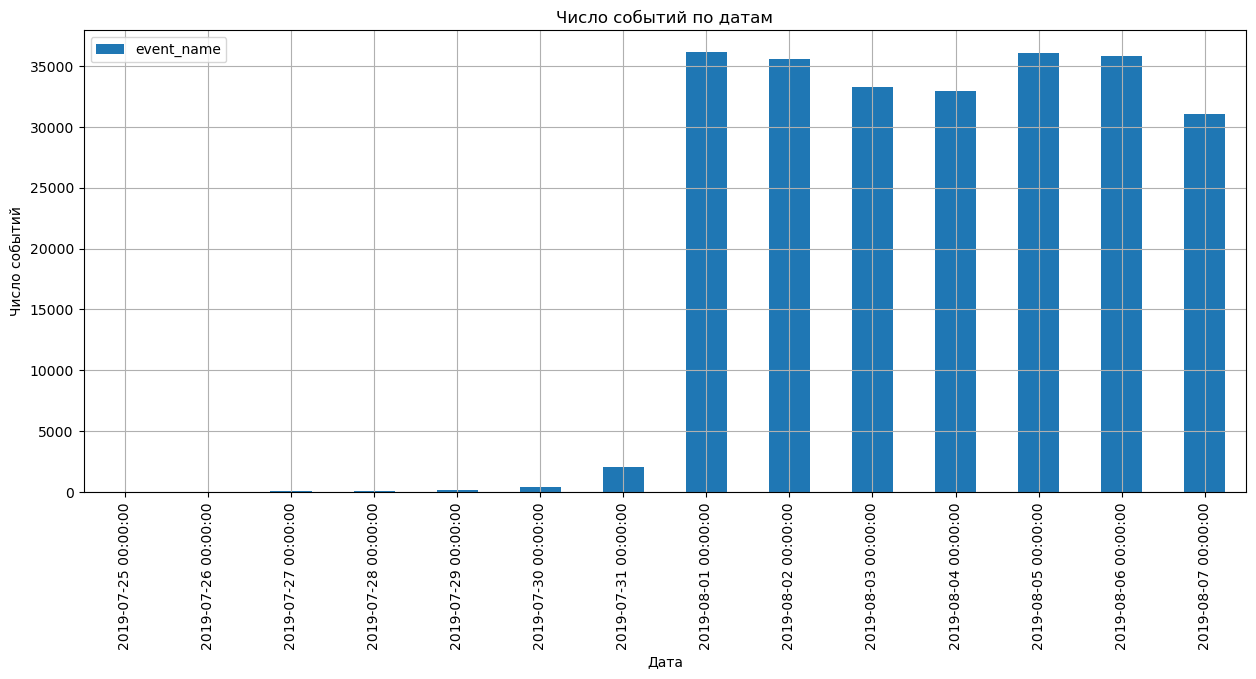

In [18]:
(
    df
    .groupby('event_date').agg({'event_name':'count'})
    .plot(kind='bar',
          grid=True,
          figsize=(15,6)
         )
)
plt.title('Число событий по датам')
plt.xlabel('Дата')
plt.ylabel('Число событий')
plt.show()


По гистограмме отчетливо видно, что данные с 2019-07-25 по 2019-07-31 включительно не полные. Это произошло по техническим причинам: в логи новых дней по некоторым пользователям "доезжают" события из прошлого, что приводит к перекосу данных.

В распоряжении полные данные с 2019-08-01 по 2019-08-07

Оставлю для исследования данные с 2019-08-01

In [19]:
df['event_date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: event_date, dtype: int64

In [20]:
df_new = df.copy()
df_new = df_new.query('event_date >= "2019-08-01"')

Посчитаю сколько данных осталось

In [21]:
print('Всего событий в логе:', len(df_new))
print('Потеряно событий:', len(df)-len(df_new))
print('Потеряно событий в процентах:', "{0:.2%}".format((len(df)-len(df_new))/len(df)))
print('='*50)
print('Всего пользователей в логе:', df_new['user_id'].nunique())
users_lose = df['user_id'].nunique()-df_new['user_id'].nunique()
print('Потеряно пользователей:', users_lose)
users_lose_pct = (df['user_id'].nunique()- df_new['user_id'].nunique())/df['user_id'].nunique()
print('Потеряно пользователей в процентах:', "{0:.2%}".format(users_lose_pct))
print('='*50)
print('Среднее количество событий на одного пользователя:', df_new.groupby('user_id').agg({'event_name':'count'}).median()[0])
print('-'*50)
print(f"Располагаем данными с {df_new['event_date'].min()} по {df_new['event_date'].max()}, что составляет {df_new['event_date'].max() - df_new['event_date'].min()} дней ")

Всего событий в логе: 240887
Потеряно событий: 2826
Потеряно событий в процентах: 1.16%
Всего пользователей в логе: 7534
Потеряно пользователей: 17
Потеряно пользователей в процентах: 0.23%
Среднее количество событий на одного пользователя: 19.0
--------------------------------------------------
Располагаем данными с 2019-08-01 00:00:00 по 2019-08-07 00:00:00, что составляет 6 days 00:00:00 дней 


Данных потеряли немного. Это было видно и по гистограмме. Они не сильно повлияют на дальнейшее исследование.

Проверю количество пользователей в каждой группе. Для этого создам сводную таблицу

In [22]:
df_new.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Количество уникальных пользователей во всех группах примерно одинаковое.

**Вывод**
После проверки данных в датасете оставили только полные данные за период с 2019-08-01 по 2019-08-07 включительно. Отбросили чуть больше 1% данных, которые искажали результаты. Выяснили, что пользователи присутствуют во всех 3-х группах и их количество примерно равное.

# 3 Изучение воронки событий

Посмотрю как часто встречаются события в логах, отсортирую их по убыванию

In [23]:
df_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

По частоте события располагаются в следующем порядке:
1. `MainScreenAppear` - открытие главного экрана
2. `OffersScreenAppear` - открытие экрана с предложениями
3. `CartScreenAppear` - открытие экрана корзины
4. `PaymentScreenSuccessful` - открытие экрана с успешной оплатой
5. `Tutorial` - открытие экрана с руководством по использованию приложения.

Посчитаю сколько уникальных пользователей совершали каждое из этих событий и выведу их долю от общего количества пользователей

In [24]:
user_cnt = (
    df_new
    .groupby('event_name', as_index=False).agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
    .rename(columns={'user_id':'user_cnt'})
)
user_cnt['user_pct'] = (user_cnt['user_cnt']/df_new['user_id'].nunique()*100).round(2)
user_cnt

,event_name,user_cnt,user_pct
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Было бы логичным предположить, что события должны идти в таком порядке:
1. `Tutorial` - открытие экрана с руководством по использованию приложения.
2. `MainScreenAppear` - открытие главного экрана
3. `OffersScreenAppear` - открытие экрана с предложениями
4. `CartScreenAppear` - открытие экрана корзины
5. `PaymentScreenSuccessful` - открытие экрана с успешной оплатой

Но экран с руководством по использованию приложения открывается меньше всего. Предположу, что руководство находится где-то в меню приложения и пользователи его не открывают. Остальные события идут в логическом порядке и выстраиваются в последовательную цепочку.

Удалю событие Tutorial из датафрейма для корректного расчета доли пользователей на каждом шаге

In [25]:
user_cnt = user_cnt.query('event_name != "Tutorial"').copy()

Добавлю столбец с долей пользователей на каждом следующем шаге воронки. Т.е. посчитаю отношение числа пользователей события OffersScreenAppear к MainScreenAppear, а события CartScreenAppear к OffersScreenAppear и т.д.

In [26]:
user_cnt['user_step_pct'] = (user_cnt['user_cnt']/user_cnt['user_cnt'].shift(1)*100).round(2)
user_cnt.loc[:, 'user_step_pct'] = user_cnt.loc[:, 'user_step_pct'].fillna('')
user_cnt

,event_name,user_cnt,user_pct,user_step_pct
1,MainScreenAppear,7419,98.47,
2,OffersScreenAppear,4593,60.96,61.91
0,CartScreenAppear,3734,49.56,81.3
3,PaymentScreenSuccessful,3539,46.97,94.78


При переходе с первого шага на второй теряется почти 40% пользователей. Это очень большой отток. 

От первого события до оплаты доходит почти 47% пользователей.

**Вывод** Воронка событий происходит в следующем порядке:
- MainScreenAppear - открытие главного экрана
- OffersScreenAppear - открытие экрана с предложениями
- CartScreenAppear - открытие экрана корзины
- PaymentScreenSuccessful - открытие экрана с успешной оплатой

Событие Tutorial проходят не все пользователи

При переходе с первого шага на второй теряется почти 40% пользователей. 
От первого события до оплаты доходит почти 47% пользователей.

# 4 Изучение результатов эксперимента

Еще раз выведу количество пользователей в каждой экспериментальной группе. 

In [27]:
user_by_group = df_new.groupby('group')['user_id'].nunique()
user_by_group

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Создам таблицу, в которой будут отображены количество и доля пользователей каждого события по группам

In [28]:
event_by_user_group = (
    df_new
    .pivot_table(
        index='event_name',
        columns = 'group',
        values = 'user_id',
        aggfunc='nunique')
    .reset_index()
    .sort_values(by='A1', ascending=False)
)
event_by_user_group['%_us_a1'] = (event_by_user_group['A1']/user_by_group['A1']*100).round(2)
event_by_user_group['%_us_a2'] = (event_by_user_group['A2']/user_by_group['A2']*100).round(2)
event_by_user_group['%_us_b'] = (event_by_user_group['B']/user_by_group['B']*100).round(2)
event_by_user_group[['event_name','A1','%_us_a1','A2','%_us_a2','B','%_us_b']]       

group,event_name,A1,%_us_a1,A2,%_us_a2,B,%_us_b
1,MainScreenAppear,2450,98.63,2476,98.53,2493,98.27
2,OffersScreenAppear,1542,62.08,1520,60.49,1531,60.35
0,CartScreenAppear,1266,50.97,1238,49.26,1230,48.48
3,PaymentScreenSuccessful,1200,48.31,1158,46.08,1181,46.55
4,Tutorial,278,11.19,283,11.26,279,11.00


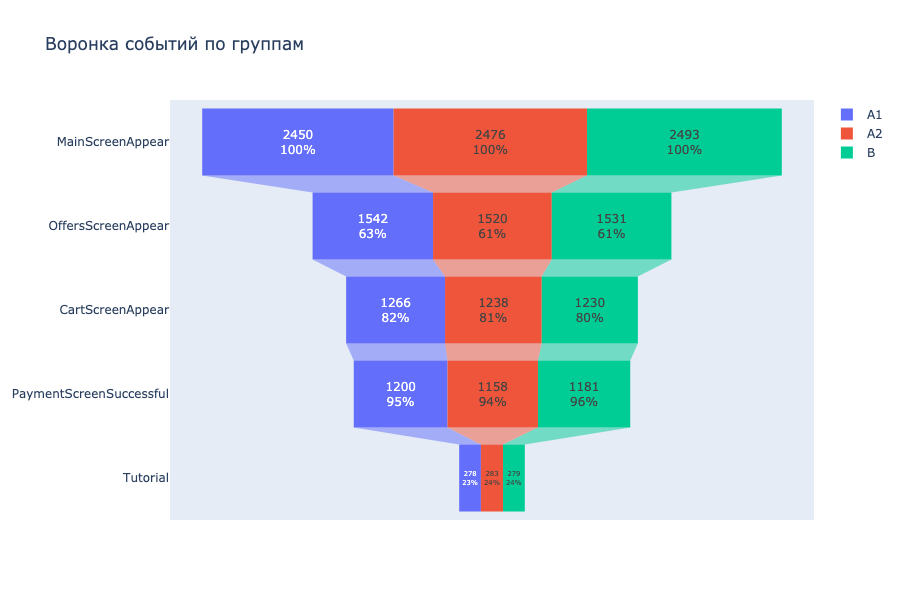

In [46]:
# Визуализирую воронку
fig = go.Figure(layout=dict(title=dict(text="Воронка событий по группам")))

fig.add_trace(go.Funnel(
    name = 'A1',
    y = event_by_user_group['event_name'],
    x = event_by_user_group['A1'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = event_by_user_group['event_name'],
    x = event_by_user_group['A2'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = event_by_user_group['event_name'],
    x = event_by_user_group['B'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show(renderer='png', width=900, height=600)

На визуальном отображении воронки событий заменто, что доли пользователей в группах на каждом этапе примерно равны.

In [30]:
def z_test(group_1, group_2, alpha):
    for i in event_by_user_group.index:
        # пропорция успехов в первой группе:
        p1 = event_by_user_group[group_1][i]/user_by_group[group_1]

        # пропорция успехов во второй группе:
        p2 = event_by_user_group[group_2][i]/user_by_group[group_2]

        # пропорция успехов в комбинированном датасете:
        p_combined = (event_by_user_group[group_1][i] + event_by_user_group[group_2][i]) / (user_by_group[group_1] + user_by_group[group_2])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/user_by_group[group_1] + 1/user_by_group[group_2]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        # Т.к. всего проведем 20 тестов, то посчитаем уровень статистической значимости с поправкой Боферрони
        bonferroni_alpha = alpha/20 
        
        print('p-значение события {} между группами {} и {} равно {}'.format(event_by_user_group['event_name'][i], group_1, group_2, p_value))

        if p_value < bonferroni_alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            ) 
        print('='*50)

**Проведу z-тест между группами А1 и А2 по всем событиям.**
- H0 - доли между группами А1 и А2 равны
- H1 - доли между группами А1 и А2 не равны

Т.к. тест длился всего 6 дней то не буду к нему слишком строга и установлю уровень статистической значимости 0,05.

In [31]:
z_test('A1', 'A2', 0.05)

p-значение события MainScreenAppear между группами A1 и A2 равно 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события OffersScreenAppear между группами A1 и A2 равно 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события CartScreenAppear между группами A1 и A2 равно 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события PaymentScreenSuccessful между группами A1 и A2 равно 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события Tutorial между группами A1 и A2 равно 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам теста различие между группами А1 и А2 незначительное. Выбор контрольных групп сработал корректно.

**Проведу z-тест между группами А1 и В по всем событиям.**
- H0 - доли между группами А1 и В равны
- H1 - доли между группами А1 и В не равны

In [32]:
z_test('A1', 'B', 0.05)

p-значение события MainScreenAppear между группами A1 и B равно 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события OffersScreenAppear между группами A1 и B равно 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события CartScreenAppear между группами A1 и B равно 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события PaymentScreenSuccessful между группами A1 и B равно 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события Tutorial между группами A1 и B равно 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проведу z-тест между группами А2 и В по всем событиям.**
- H0 - доли между группами А1 и В равны
- H1 - доли между группами А1 и В не равны

In [33]:
z_test('A2', 'B', 0.05)

p-значение события MainScreenAppear между группами A2 и B равно 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события OffersScreenAppear между группами A2 и B равно 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события CartScreenAppear между группами A2 и B равно 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события PaymentScreenSuccessful между группами A2 и B равно 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события Tutorial между группами A2 и B равно 0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Добавлю в таблицs **event_by_user_group** и **user_by_group** колонку **A**, которая объединит значения колонок A1 и A2

In [34]:
event_by_user_group['A'] = event_by_user_group['A1'] + event_by_user_group['A2']
user_by_group['A'] = user_by_group['A1'] + user_by_group['A2']
display(event_by_user_group)
display(user_by_group)

group,event_name,A1,A2,B,%_us_a1,%_us_a2,%_us_b,A
1,MainScreenAppear,2450,2476,2493,98.63,98.53,98.27,4926
2,OffersScreenAppear,1542,1520,1531,62.08,60.49,60.35,3062
0,CartScreenAppear,1266,1238,1230,50.97,49.26,48.48,2504
3,PaymentScreenSuccessful,1200,1158,1181,48.31,46.08,46.55,2358
4,Tutorial,278,283,279,11.19,11.26,11.00,561


group
A1    2484
A2    2513
B     2537
A     4997
Name: user_id, dtype: int64

**Проведу z-тест между группами A и В по всем событиям.**
- H0 - доли между группами A и В равны
- H1 - доли между группами A и В не равны

In [35]:
z_test('A', 'B', 0.05)

p-значение события MainScreenAppear между группами A и B равно 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события OffersScreenAppear между группами A и B равно 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события CartScreenAppear между группами A и B равно 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события PaymentScreenSuccessful между группами A и B равно 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение события Tutorial между группами A и B равно 0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам тестов выяснили, что статистические критерии не находят разницу  между экспериментальными группами. Было проведено 20 тестов и на их основании нельзя считать доли разными. Можно сделать вывод, что на пользователей никак не влияет изменение шрифта.

# Вывод

После проверки данных в датасете оставили только полные данные за период с 2019-08-01 по 2019-08-07 включительно. Отбросили чуть больше 1% данных, которые искажали результаты. Выяснили, что пользователи присутствуют во всех 3-х группах и их количество примерно равное.

Воронка событий происходит в следующем порядке:

- MainScreenAppear - открытие главного экрана
- OffersScreenAppear - открытие экрана с предложениями
- CartScreenAppear - открытие экрана корзины
- PaymentScreenSuccessful - открытие экрана с успешной оплатой

Событие Tutorial проходят не все пользователи

При переходе с первого шага на второй теряется почти 40% пользователей. Возможно одной из причин как раз является то, что не все пользователи открывают руководство по использованию приложением.
От первого события до оплаты доходит почти 47% пользователей.

По результатам тестирования, статистически значимых различий между А1, А2 и В группами мы не нашлось. Это означает, что гипотеза о том, что изменение шрифта на главной странице повлияет на пользователей, не подтвердилась.

Рекомендации:
- сделать страницу Tutorial обязательной к прохождению. Проверить влияние этого эксперимента на контрольных группах.
- рассмотреть возможность увеличить период эксперимента по шрифтам, т.к. у нас данные за очень небольшой промежуток времени, и повторно провести z-тесты.